## Ski resorts

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("farheenshaukat/ski-resort")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\matan\.cache\kagglehub\datasets\farheenshaukat\ski-resort\versions\1


In [8]:
import pandas as pd

# Assuming the dataset is a CSV file in the downloaded path
import os

# Find a CSV file in the downloaded directory
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
if csv_files:
    data_file = os.path.join(path, csv_files[0])
    # Try with encoding='latin1' if utf-8 fails
    try:
        ski_df = pd.read_csv(data_file)
    except UnicodeDecodeError:
        ski_df = pd.read_csv(data_file, encoding='latin1')
    print("Columns:", list(ski_df.columns))
    print(ski_df.describe())
else:
    print("No CSV file found in the dataset directory.")

ski_df.columns = ski_df.columns.str.strip()





Columns: ['ID', 'Resort', 'Latitude', 'Longitude', 'Country', 'Continent', 'Price', 'Season', 'Highest point', 'Lowest point', 'Beginner slopes', 'Intermediate slopes', 'Difficult slopes', 'Total slopes', 'Longest run', 'Snow cannons', 'Surface lifts', 'Chair lifts', 'Gondola lifts', 'Total lifts', 'Lift capacity', 'Child friendly', 'Snowparks', 'Nightskiing', 'Summer skiing']
               ID    Latitude   Longitude       Price  Highest point  \
count  499.000000  499.000000  499.000000  499.000000     499.000000   
mean   250.000000   43.205684   -6.006784   48.721443    2160.589178   
std    144.193157   15.975790   59.990459   21.718733     774.339805   
min      1.000000  -45.054960 -149.740657    0.000000     163.000000   
25%    125.500000   43.672650    1.380975   36.000000    1594.000000   
50%    250.000000   46.347316    8.206372   45.000000    2175.000000   
75%    374.500000   47.327089   12.429237   54.000000    2700.000000   
max    499.000000   67.784406  176.876668  1

In [9]:
ski_df = ski_df.fillna(0)
non_numeric_cols = ski_df.select_dtypes(include=['object']).columns

for col in non_numeric_cols:
    # Convert to numeric codes
    ski_df[col+"_numeric"], _ = pd.factorize(ski_df[col])
ski_df.head()

,ID,Resort,Latitude,Longitude,Country,Continent,Price,Season,Highest point,Lowest point,...,Nightskiing,Summer skiing,Resort_numeric,Country_numeric,Continent_numeric,Season_numeric,Child friendly_numeric,Snowparks_numeric,Nightskiing_numeric,Summer skiing_numeric
0,1,Hemsedal,60.928244,8.383487,Norway,Europe,46,November - May,1450,620,...,Yes,No,0,0,0,0,0,0,0,0
1,2,Geilosiden Geilo,60.534526,8.206372,Norway,Europe,44,November - April,1178,800,...,Yes,No,1,0,0,1,0,0,0,0
2,3,Golm,47.057810,9.828167,Austria,Europe,48,December - April,2110,650,...,No,No,2,1,0,2,0,1,1,0
3,4,Red Mountain Resort-Rossland,49.105520,-117.846280,Canada,North America,60,December - April,2075,1185,...,Yes,No,3,2,1,2,0,0,0,0
4,5,Hafjell,61.230369,10.529014,Norway,Europe,45,November - April,1030,195,...,Yes,No,4,0,0,1,0,0,0,0


In [10]:
print(ski_df.columns)
print(ski_df.iloc[0])  

Index(['ID', 'Resort', 'Latitude', 'Longitude', 'Country', 'Continent',
       'Price', 'Season', 'Highest point', 'Lowest point', 'Beginner slopes',
       'Intermediate slopes', 'Difficult slopes', 'Total slopes',
       'Longest run', 'Snow cannons', 'Surface lifts', 'Chair lifts',
       'Gondola lifts', 'Total lifts', 'Lift capacity', 'Child friendly',
       'Snowparks', 'Nightskiing', 'Summer skiing', 'Resort_numeric',
       'Country_numeric', 'Continent_numeric', 'Season_numeric',
       'Child friendly_numeric', 'Snowparks_numeric', 'Nightskiing_numeric',
       'Summer skiing_numeric'],
      dtype='object')
ID                                     1
Resort                          Hemsedal
Latitude                       60.928244
Longitude                       8.383487
Country                           Norway
Continent                         Europe
Price                                 46
Season                    November - May
Highest point                       1450
Lowe

In [11]:
ski_df.head()

,ID,Resort,Latitude,Longitude,Country,Continent,Price,Season,Highest point,Lowest point,...,Nightskiing,Summer skiing,Resort_numeric,Country_numeric,Continent_numeric,Season_numeric,Child friendly_numeric,Snowparks_numeric,Nightskiing_numeric,Summer skiing_numeric
0,1,Hemsedal,60.928244,8.383487,Norway,Europe,46,November - May,1450,620,...,Yes,No,0,0,0,0,0,0,0,0
1,2,Geilosiden Geilo,60.534526,8.206372,Norway,Europe,44,November - April,1178,800,...,Yes,No,1,0,0,1,0,0,0,0
2,3,Golm,47.057810,9.828167,Austria,Europe,48,December - April,2110,650,...,No,No,2,1,0,2,0,1,1,0
3,4,Red Mountain Resort-Rossland,49.105520,-117.846280,Canada,North America,60,December - April,2075,1185,...,Yes,No,3,2,1,2,0,0,0,0
4,5,Hafjell,61.230369,10.529014,Norway,Europe,45,November - April,1030,195,...,Yes,No,4,0,0,1,0,0,0,0


## Rank Ski DF

In [14]:
rank_path = 'data\ski-resorts_ranks.csv'
rank_df = pd.read_csv(rank_path)
# Split 'location_coordinate' into 'location_lat' and 'location_log'
def extract_lat(coord):
    try:
        if isinstance(coord, dict):
            return float(coord.get('lat', None))
        elif isinstance(coord, str):
            import ast
            d = ast.literal_eval(coord)
            return float(d.get('lat', None))
    except Exception:
        return None

def extract_log(coord):
    try:
        if isinstance(coord, dict):
            return float(coord.get('long', None))
        elif isinstance(coord, str):
            import ast
            d = ast.literal_eval(coord)
            return float(d.get('long', None))
    except Exception:
        return None

rank_df['location_lat'] = rank_df['location_coordinate'].apply(extract_lat)
rank_df['location_long'] = rank_df['location_coordinate'].apply(extract_log)

rank_df.columns

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matan\AppData\Local\Temp\ipykernel_3796\4038188115.py:1: SyntaxWarning: invalid escape sequence '\s'
  rank_path = 'data\ski-resorts_ranks.csv'


Index(['rank', 'name', 'rating', 'url', 'location_coordinate',
       'location_country', 'location_region', 'elevation_top_m',
       'elevation_difference_m', 'total_slope_length_km', 'number_of_lifts',
       'number_of_slopes', 'annual_snowfall_cm', 'number_of_matches',
       'location_lat', 'location_long'],
      dtype='object')

In [15]:
rank_df.iloc[0]

rank                                                         1
name                                       4 Vallées (Verbier)
rating                                                  1311.7
url                                     http://www.4vallees.ch
location_coordinate       {'lat': '46.1013', 'long': '7.2263'}
location_country                                   Switzerland
location_region                                         Valais
elevation_top_m                                         3330.0
elevation_difference_m                                  1980.0
total_slope_length_km                                    412.0
number_of_lifts                                           68.0
number_of_slopes                                         307.0
annual_snowfall_cm                                       500.0
number_of_matches                                           65
location_lat                                           46.1013
location_long                                          

# Resort name matching


In [16]:
import re, unicodedata
from unidecode import unidecode   # pip install Unidecode
from rapidfuzz import process, fuzz  # pip install rapidfuzz

STOPWORDS = {
    "ski", "resort", "area", "mountain", "mt", "snow",
    "center", "centre", "valley", "park", "domain", "zone"
}

def normalise(name: str) -> str:
    """
    Lower-case, remove accents & punctuation, drop generic words,
    collapse whitespace.  Returns a canonical form suitable for matching.
    """
    n = unidecode(name)                    # Åre  -> Are
    n = n.lower()
    n = re.sub(r"[()\-_/]", " ", n)        # replace separators by space
    tokens = re.split(r"\W+", n)
    keep = [t for t in tokens if t and t not in STOPWORDS]
    return " ".join(keep)

ski_df["key"]  = ski_df["Resort"].map(normalise)
rank_df["key"] = rank_df["name"]  .map(normalise)

merged = ski_df.merge(rank_df[["key", "rank"]], on="key", how="left")
rank_index = dict(zip(rank_df["key"], rank_df["rank"]))
rank_keys  = list(rank_index.keys())

THRESHOLD = 85            # token_set_ratio score (0-100)

def fuzzy_lookup(row):
    if not pd.isna(row["rank"]):
        return row["rank"]          # already matched
    cand, score, _ = process.extractOne(
        row["key"], rank_keys, scorer=fuzz.token_set_ratio)
    return rank_index[cand] if score >= THRESHOLD else None

merged["rank"] = merged.apply(fuzzy_lookup, axis=1)

import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2-lat1, lon2-lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

def geo_resolve(row):
    if not pd.isna(row["rank"]):          # matched already
        return row["rank"]
    # take the ten best fuzzy candidates, then pick nearest
    cands = process.extract(
        row["key"], rank_keys, scorer=fuzz.token_set_ratio, limit=10)
    if not cands:
        return None
    ski_lat, ski_lon = row["Latitude"], row["Longitude"]
    best_rank, best_d = None, np.inf
    for cand_key, _, _ in cands:
        r = rank_df.loc[rank_df["key"] == cand_key].iloc[0]
        d = haversine(ski_lat, ski_lon, r["location_lat"], r["location_long"])
        if d < best_d:
            best_d, best_rank = d, r["rank"]
    return best_rank if best_d < 15 else None   # 15 km cut-off

merged["rank"] = merged.apply(geo_resolve, axis=1)


In [17]:
# Count the number of NaN values in the 'rank' column of merged
num_nan_rank = merged['rank'].isna().sum()
merged = merged.dropna(subset=['rank'])

merged.describe()


,ID,Latitude,Longitude,Price,Highest point,Lowest point,Beginner slopes,Intermediate slopes,Difficult slopes,Total slopes,...,Lift capacity,Resort_numeric,Country_numeric,Continent_numeric,Season_numeric,Child friendly_numeric,Snowparks_numeric,Nightskiing_numeric,Summer skiing_numeric,rank
count,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,...,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000
mean,245.375000,45.627298,-14.019613,50.907407,2195.837963,1221.909722,33.043981,39.543981,17.358796,89.946759,...,32229.465278,244.375000,6.895833,0.391204,4.437500,0.002315,0.226852,0.594907,0.027778,387.520833
std,141.657124,7.542905,58.433261,21.953669,761.409724,598.777175,47.833726,44.073688,20.349578,100.194263,...,41284.761317,141.657124,4.796149,0.821530,6.074234,0.048113,0.419282,0.491479,0.164526,486.760283
min,1.000000,-41.165560,-149.740657,0.000000,492.000000,36.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,125.750000,44.450000,-0.402829,39.000000,1632.000000,810.000000,11.000000,14.750000,3.750000,35.000000,...,11890.000000,124.750000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,95.750000
50%,243.500000,46.392812,7.578079,46.000000,2223.000000,1152.500000,19.500000,26.000000,10.000000,60.000000,...,18885.500000,242.500000,7.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,243.500000
75%,365.250000,47.325526,11.343871,56.000000,2721.250000,1502.000000,32.250000,45.250000,25.000000,103.000000,...,33025.750000,364.250000,10.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,481.750000
max,499.000000,67.784406,147.244179,141.000000,3914.000000,3286.000000,312.000000,239.000000,126.000000,600.000000,...,252280.000000,498.000000,37.000000,4.000000,29.000000,1.000000,1.000000,1.000000,1.000000,3200.000000


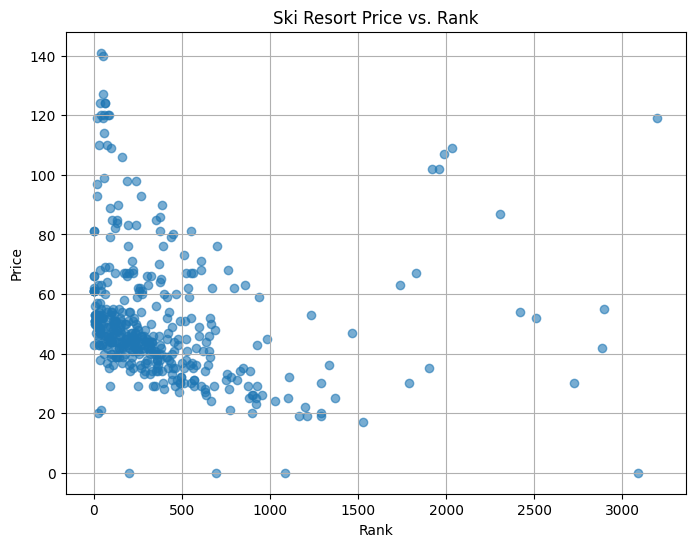

Correlation between Price and rank: -0.136


In [18]:
import matplotlib.pyplot as plt

# Plot Price vs. rank
plt.figure(figsize=(8, 6))
plt.scatter(merged['rank'], merged['Price'], alpha=0.6)
plt.xlabel('Rank')
plt.ylabel('Price')
plt.title('Ski Resort Price vs. Rank')
plt.grid(True)
plt.show()

# Print the correlation between Price and rank
correlation = merged['Price'].corr(merged['rank'])
print(f"Correlation between Price and rank: {correlation:.3f}")


In [19]:
import numpy as np

# Filter out rows with missing Rank or Price
df_valid = merged.dropna(subset=['rank', 'Price'])

counter = 0
n_samples = 10000  # Number of random pairs to sample

for _ in range(n_samples):
    # Randomly sample 2 different resorts
    sample = df_valid.sample(2, replace=False)
    rank1, price1 = sample.iloc[0]['rank'], sample.iloc[0]['Price']
    rank2, price2 = sample.iloc[1]['rank'], sample.iloc[1]['Price']
    
    # Lower rank means higher ranking (closer to 1)
    if rank1 < rank2:
        if price1 > price2:
            counter += 1
        else:
            counter -= 0
    elif rank2 < rank1:
        if price2 > price1:
            counter += 1
        else:
            counter -= 0
    # If ranks are equal, do nothing

print(f"Counter after {n_samples} samples: {counter}")

Counter after 10000 samples: 6432


In [20]:
import numpy as np

def name_similarity(a, b):
    # Normalize
    a, b = a.strip().lower(), b.strip().lower()
    # Calculate overlap as the length of the longest common substring divided by the length of the shorter name
    from difflib import SequenceMatcher
    ratio = SequenceMatcher(None, a, b).ratio()
    return ratio

# Prepare the new column
ski_df['Rank'] = np.nan
ski_df['Other_name'] = np.nan

# For faster lookup, group rank_df by country
rank_country_groups = rank_df.groupby('location_country')

for idx, row in ski_df.iterrows():
    country = row['Country']
    resort = row['Resort']
    # Only check if country exists in rank_df
    if country in rank_country_groups.groups:
        candidates = rank_country_groups.get_group(country)
        found = False
        for _, r in candidates.iterrows():
            sim = name_similarity(resort, r['name'])
            if sim >= 0.5:
                ski_df.at[idx, 'Rank'] = r['rank']
                ski_df.at[idx, 'Other_name'] = r['name']
                found = True
                break  # Stop at first match

# ski_df['Rank'] now contains the matched rank or NaN if no match was found

C:\Users\matan\AppData\Local\Temp\ipykernel_3796\2046772991.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Hemsedal' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ski_df.at[idx, 'Other_name'] = r['name']


In [21]:
print(ski_df['Rank'].isna().sum())
part_df = ski_df.dropna(axis=0)
ski_df.head(10)

209


,ID,Resort,Latitude,Longitude,Country,Continent,Price,Season,Highest point,Lowest point,...,Country_numeric,Continent_numeric,Season_numeric,Child friendly_numeric,Snowparks_numeric,Nightskiing_numeric,Summer skiing_numeric,key,Rank,Other_name
0,1,Hemsedal,60.928244,8.383487,Norway,Europe,46,November - May,1450,620,...,0,0,0,0,0,0,0,hemsedal,69.0,Hemsedal
1,2,Geilosiden Geilo,60.534526,8.206372,Norway,Europe,44,November - April,1178,800,...,0,0,1,0,0,0,0,geilosiden geilo,NaN,NaN
2,3,Golm,47.057810,9.828167,Austria,Europe,48,December - April,2110,650,...,1,0,2,0,1,1,0,golm,250.0,Golm
3,4,Red Mountain Resort-Rossland,49.105520,-117.846280,Canada,North America,60,December - April,2075,1185,...,2,1,2,0,0,0,0,red rossland,74.0,Revelstoke Mountain Resort
4,5,Hafjell,61.230369,10.529014,Norway,Europe,45,November - April,1030,195,...,0,0,1,0,0,0,0,hafjell,184.0,Kvitfjell
5,6,Voss,60.683706,6.407905,Norway,Europe,43,November - May,960,284,...,0,0,0,0,0,1,0,voss,288.0,Voss Resort
6,7,Porter,-39.670988,176.876668,New Zealand,Oceania,61,June - September,1980,1300,...,3,2,3,1,1,1,1,porter,NaN,NaN
7,8,Nevados de Chilla?n,-36.613844,-72.071805,Chile,South America,57,June - October,2700,1600,...,4,3,4,0,0,1,1,nevados de chilla n,NaN,NaN
8,9,Hochschwarzeck,47.628373,12.920528,Germany,Europe,22,December - April,1385,1030,...,5,0,2,0,1,1,0,hochschwarzeck,1048.0,Schwarzenbachlift
9,10,Rossfeld - Berchtesgaden - Oberau,47.651306,13.058977,Germany,Europe,20,December - April,1554,1300,...,5,0,2,0,0,0,0,rossfeld berchtesgaden oberau,2902.0,Spielberg-Obernhausen


In [22]:
hemsedal_in_rank = rank_df['name'].str.contains('Panorama', case=False, na=False)
hemmedal_matches = rank_df[hemsedal_in_rank]
if not hemmedal_matches.empty:
    print("Found 'Panorama' in rank_df['name']:")
    print(hemmedal_matches)
else:
    print("No match for 'Panorama' in rank_df['name'].")


Found 'Panorama' in rank_df['name']:
     rank             name  rating                              url  \
260   261         Panorama  1001.7  https://www.panoramaresort.com/   
665   666  Fujimi Panorama   937.2    http://www.fujimipanorama.com   
668   669    Panorama Area   936.5   https://www.hachimantai.co.jp/   

                         location_coordinate location_country  \
260  {'lat': '50.4606', 'long': '-116.2375'}           Canada   
665   {'lat': '35.9450', 'long': '138.2700'}            Japan   
668   {'lat': '39.9422', 'long': '140.9778'}            Japan   

       location_region  elevation_top_m  elevation_difference_m  \
260   British Columbia           2365.0                  1215.0   
665  Nagano Prefecture           1780.0                   730.0   
668   Iwate Prefecture           1000.0                   460.0   

     total_slope_length_km  number_of_lifts number_of_slopes  \
260                  112.0             10.0             39.0   
665                 

In [23]:
# Rank ATE
# Rank ATE - Fixed Version
print("=== DIAGNOSTIC INFORMATION ===")

# Check what columns we have
print("Available columns containing 'snow':")
snow_columns = [col for col in part_df.columns if 'snow' in col.lower()]
print(snow_columns)

# Check the actual values in Snowparks columns
print("\nChecking Snowparks columns:")
if 'Snowparks' in part_df.columns:
    print("'Snowparks' column values:")
    print(part_df['Snowparks'].value_counts())
    
if 'Snowparks_numeric' in part_df.columns:
    print("\n'Snowparks_numeric' column values:")
    print(part_df['Snowparks_numeric'].value_counts())

# Use the correct column name (likely Snowparks_numeric based on your data processing)
snowparks_col = 'Snowparks_numeric' if 'Snowparks_numeric' in part_df.columns else 'Snowparks'

# Check if we have data for both groups
with_sp_data = part_df[part_df[snowparks_col] == 1]['Rank']
without_sp_data = part_df[part_df[snowparks_col] == 0]['Rank']

print(f"\nNumber of resorts with snowparks (treatment=1): {len(with_sp_data)}")
print(f"Number of resorts without snowparks (treatment=0): {len(without_sp_data)}")

# Calculate ATE only if we have data in both groups
if len(with_sp_data) > 0 and len(without_sp_data) > 0:
    with_sp = np.mean(with_sp_data)
    without_sp = np.mean(without_sp_data)
    ate = with_sp - without_sp
    
    print(f"\nMean Rank for resorts WITH snowparks: {with_sp:.2f}")
    print(f"Mean Rank for resorts WITHOUT snowparks: {without_sp:.2f}")
    print(f"Average Treatment Effect (ATE): {ate:.2f}")
    
    # Interpretation
    if ate < 0:
        print("Interpretation: Having snowparks is associated with BETTER ranking (lower rank number)")
    else:
        print("Interpretation: Having snowparks is associated with WORSE ranking (higher rank number)")
else:
    print("\nCannot calculate ATE - missing data in one or both treatment groups")
    if len(with_sp_data) == 0:
        print("No resorts with snowparks found in the dataset")
    if len(without_sp_data) == 0:
        print("No resorts without snowparks found in the dataset")

=== DIAGNOSTIC INFORMATION ===
Available columns containing 'snow':
['Snow cannons', 'Snowparks', 'Snowparks_numeric']

Checking Snowparks columns:
'Snowparks' column values:
Snowparks
Yes    221
No      69
Name: count, dtype: int64

'Snowparks_numeric' column values:
Snowparks_numeric
0    221
1     69
Name: count, dtype: int64

Number of resorts with snowparks (treatment=1): 69
Number of resorts without snowparks (treatment=0): 221

Mean Rank for resorts WITH snowparks: 552.39
Mean Rank for resorts WITHOUT snowparks: 281.80
Average Treatment Effect (ATE): 270.59
Interpretation: Having snowparks is associated with WORSE ranking (higher rank number)


## Predict the target

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

target = 'Price'
numeric_cols = ski_df.select_dtypes(include=[np.number]).columns
confounders = [col for col in numeric_cols if col not in [target, 'Rank']]
X = ski_df[confounders]
treatment = 'Snowparks_numeric' #'Nightskiing'
# T = df_student[treatment]
y = ski_df[target] #['Adult']
X = ski_df[confounders]
# Remove the treatment column from confounders and select only those columns
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)







In [25]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
print("Linear Regression Train R^2:", lr_reg.score(X_train, y_train))
print("Linear Regression Test R^2:", lr_reg.score(X_test, y_test))

# Train a Random Forest Regressor with reduced complexity to prevent overfitting
rf = RandomForestRegressor(
    n_estimators=50,        # fewer trees
    max_depth=4,            # limit tree depth
    min_samples_leaf=10,    # require more samples per leaf
    random_state=42
)
rf.fit(X_train, y_train)

# Print train and test R^2 score
print("Random Forest Train R^2:", rf.score(X_train, y_train))
print("Random Forest Test R^2:", rf.score(X_test, y_test))

xgb = XGBRegressor(
    n_estimators=50,        # fewer boosting rounds
    max_depth=3,            # shallower trees
    min_child_weight=10,    # require more samples per leaf
    subsample=0.7,          # use a fraction of data for each tree
    colsample_bytree=0.7,   # use a fraction of features for each tree
    random_state=42
)
xgb.fit(X_train, y_train)
print("XGBoost Train R^2:", xgb.score(X_train, y_train))
print("XGBoost Test R^2:", xgb.score(X_test, y_test))


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate Linear Regression
y_pred_lr = lr_reg.predict(X_test)
print("Linear Regression Metrics:")
print("  R^2:", r2_score(y_test, y_pred_lr))
print("  MSE:", mean_squared_error(y_test, y_pred_lr))
print("  MAE:", mean_absolute_error(y_test, y_pred_lr))

# Evaluate Random Forest
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Metrics:")
print("  R^2:", r2_score(y_test, y_pred_rf))
print("  MSE:", mean_squared_error(y_test, y_pred_rf))
print("  MAE:", mean_absolute_error(y_test, y_pred_rf))

# Evaluate XGBoost
y_pred_xgb = xgb.predict(X_test)
print("\nXGBoost Metrics:")
print("  R^2:", r2_score(y_test, y_pred_xgb))
print("  MSE:", mean_squared_error(y_test, y_pred_xgb))
print("  MAE:", mean_absolute_error(y_test, y_pred_xgb))



Linear Regression Train R^2: 0.5835153870759897
Linear Regression Test R^2: 0.5578073633363885
Random Forest Train R^2: 0.7814054383679107
Random Forest Test R^2: 0.720314608011717
XGBoost Train R^2: 0.9442111849784851
XGBoost Test R^2: 0.6829768419265747
Linear Regression Metrics:
  R^2: 0.5578073633363885
  MSE: 204.55278631262837
  MAE: 10.405436395628481

Random Forest Metrics:
  R^2: 0.720314608011717
  MSE: 129.37896626637988
  MAE: 7.688478193459039

XGBoost Metrics:
  R^2: 0.6829768419265747
  MSE: 146.65093994140625
  MAE: 6.872704982757568


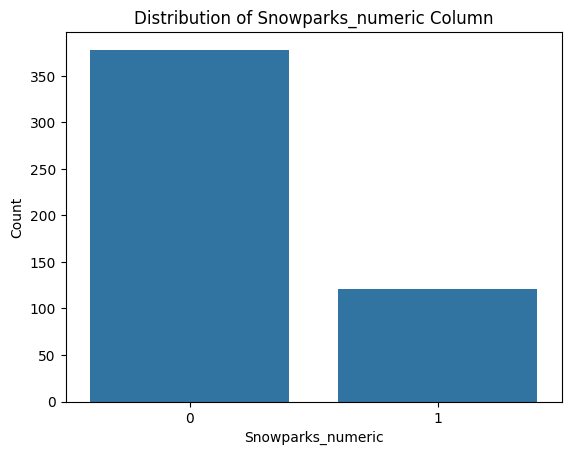

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

column  = "Snowparks_numeric" # "Snowparks"
sns.countplot(x=column, data=ski_df)
plt.title(f"Distribution of {column} Column")
plt.xlabel(column)
plt.ylabel('Count')
plt.show()

## Basic ATE Treatment = SnowParks

In [35]:
target = "Rank"
mean_price_snowparks_0 = ski_df[ski_df[column] == 0][target].mean()
mean_price_snowparks_1 = ski_df[ski_df[column] == 1][target].mean()
print("Mean Price for Snowparks=0:", round(mean_price_snowparks_0, 2))
print("Mean Price for Snowparks=1:", round(mean_price_snowparks_1, 2))

Mean Price for Snowparks=0: 281.8
Mean Price for Snowparks=1: 552.39


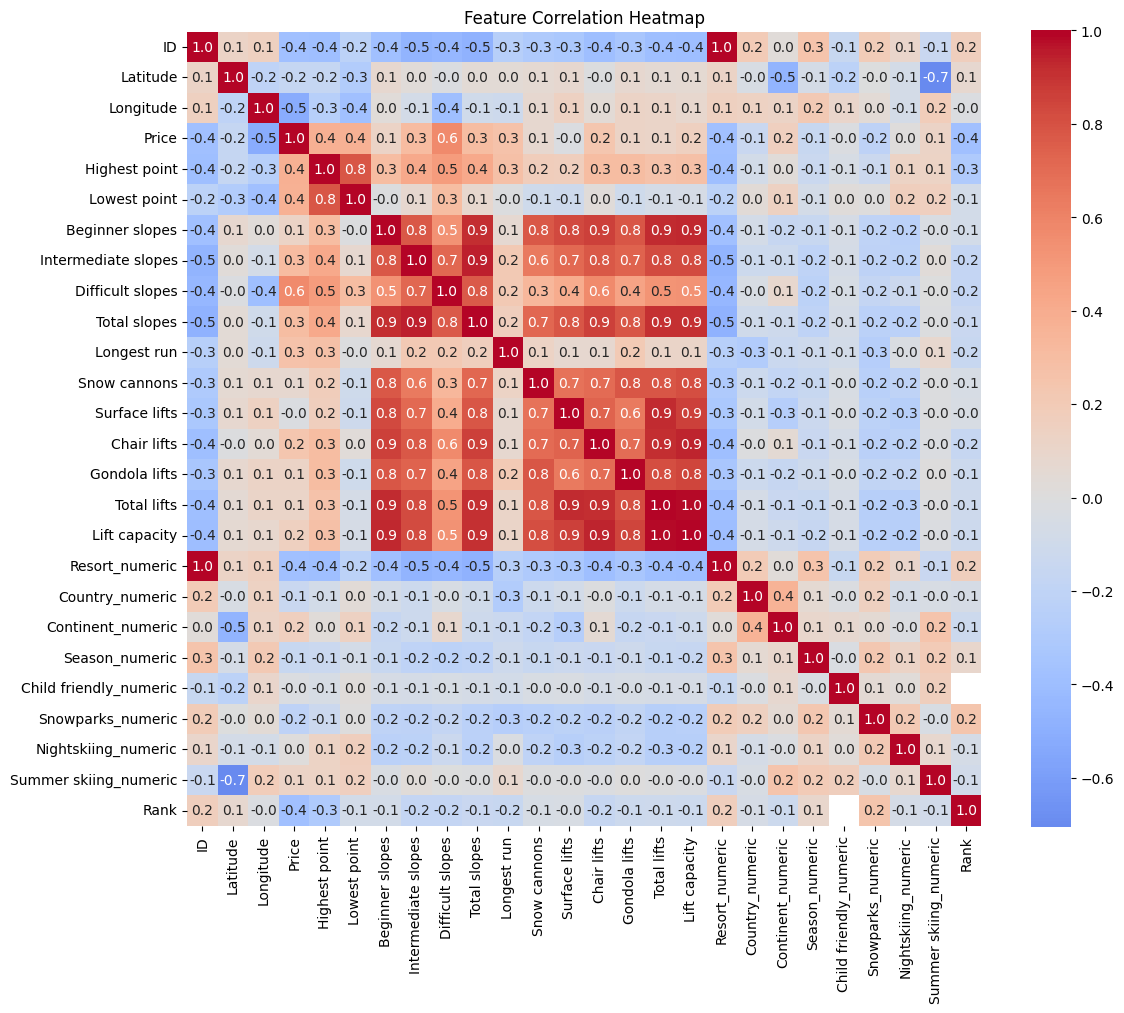

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
# Convert boolean columns to numeric (0/1)

# Calculate correlation matrix
correlation_matrix = ski_df.select_dtypes(include=['float64', 'int64']).corr()

# Create a figure with a larger size
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.1f',  # Round to 2 decimal places
            square=True)  # Make cells square

plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()